# Simple Neural Network.

Simple neural network es una librería escrita en python con fines didácticos.

En esta se encuentran implementados 3 tipos de sistemas neuronales como son:

* Clasificador binario.
* Clasificador multicalse.
* Redes neuronales multicapa.

Este notebook tiene como objetivo presentar la forma en la que están programados cada uno de los elementos de esta librería.

Se hará referencia a la ubicación de cada uno de los elementos dentro de la estructura de la librería de la siguiente forma: `simple_neural_network/package(s)/file.py`.
Siendo `simple_neural_network` la raíz de la librería.


## 1. Dependencias.

Definiremos en primer lugar las dependencias necesarias para poder utilizar esta liibrería y haremos distinción entre las que ya vienen por defecto con python y las que hay que descargar de forma explícita.

* Paquetes de python:
    * `csv`: dedicado a la lectura de datos desde ficheros csv.
    * `pickle`: utilizado para guardar y cargas los sistemas neuronales en disco y poder reutilizarlos.
    * `enum`: utilizado para la definición de enums, como por ejemplo los tipos de funciones de adtivación. De esta forma es más cómodo seleccionar una función u otra sin cometer errores, otra librerías utilizan strings.

* Paquetes externos:
    * `matplotlib`: utiliada para reprsentar información de forma gráfica.
    * `numpy`: utilizada para trabajar con matrices y poder realizar operaciones con estas de una forma más cómda y eficiente.

In [1]:
import csv
import pickle
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np


## 2. Constantes.

Ubicación: `simple_neural_network/constants/constants.py`

Se crea este archivo para un manejo más sencillo y localizado de los valores constantes de los elementos que componen la librería.


In [2]:
# Utilities
OBJECTS_SAVED_EXTENSION = '.snn'

# Logs
ERROR_RATE = 'Epoch {epoch}: {misclassified_samples} misclassified samples out of {samples} ' \
             '-> error rate = {error_rate:.2f}'

# Activation functions
ACTIVATION_FUNCTIONS = dict(STEP_FUNCTION_VALUE=0)

# Binary classifier
BINARY_CLASSIFIER = dict(LEARNING_RATE_DEFAULT_VALUE=1, MAX_EPOCHS_DEFAULT_VALUE=10)

# Multiclass classifier
MULTICLASS_CLASSIFIER = dict(LEARNING_RATE_DEFAULT_VALUE=1, MAX_EPOCHS_DEFAULT_VALUE=10)

# Multilayer neural network
MULTILAYER_NEURAL_NETWORK = dict(LEARNING_RATE_DEFAULT_VALUE=0.1, MAX_EPOCHS_DEFAULT_VALUE=20,
                                 NEURON_DIMENSION=0, NEURON_ACTIVATION_FUNCTION=1)


## 3. Utilidades.
### 3.1. Lectura de datos desde archivos CSV.

Ubicación: `simple_neural_network/utilities/data_loader/csv_data_loader.py`

Una de las utilidades de la librería es un módulo para la lectura de datos desde archivos `.csv`, ya que estos achivos son muy comunes para la representación de sets de datos.

Se puede observar como se dispone de dos métodos públicos estáticos capaces de generar un array de numpy tanto para datos como para etiquetas, siendo el tipo de datos de `np.double` y `np.intc` respectivamente.

Este array que devuelve cada método se generea a partir de los datos del archivo csv que se pasa como parámetro. Además de la ruta al archivo `.csv`, se deben introducir dos parámetros más,
el delimitador utulizado para separar los datos y si queremos omitir la primera línea del archivo, en muchos casos la primera línea se trata de la cabecera de los mismos.

* Funciones:
    * `__load_data(path_to_csv_file, delimiter, discard_first_row)`: función privada encargada de leer el archivo `.csv` pasado como parámetro y devolver un lista de datos.
    * `load_samples(path_to_csv_file, delimiter, discard_first_row)`: función cabecera que realiza una llamada a `__load_data(path_to_csv_file, delimiter, discard_first_row)` para cargar los datos de las muestras y
    devolverlos en una lista de tipo `np.double`.
    * `load_labels(path_to_csv_file, delimiter, discard_first_row)`: función cabecera que realiza una llamada a `__load_data(path_to_csv_file, delimiter, discard_first_row)` para cargar los datos de las etiquetas y
    devolverlos en una lista de tipo `np.intc`.

    Parámetros:
        * `path_to_csv_file`: ruta al archivo `.csv` que se desea leer.
        * `delimiter`: caracter delimitador utilizado para separar los valores de los datos en el fichero `.csv`, usualmente son: `,` o `;`.
        * `discard_first_row`: booleano que indica si deseamos descartar o no la primera fila del archivo.


Las dimensiones del array de datos será NxM, siendo N el número de filas y M el número de columnas del archivo `.csv`.
Y Nx1 para el array de etiquetas.

Nótese como se elimina la primera línea del archivo `.csv`, ya que contiene la descripción de las columnas.

Ejemplo de uso:

`samples.csv`
```
# sepal_length, # petal_length
5.1, 1.4
4.9, 1.4
4.7, 1.3
4.6, 1.5
```
`CSVDataLoader.load_samples(samples.csv, ',', True)` -> [[5.1, 1.4], [4.9, 1.4], [4.7, 1.3], [4.6, 1.5]]

`labels.csv`
```
# labels (0 = Iris-setosa, 1 = Iris-versicolor)
0
0
0
0
```
`CSVDataLoader.load_labels(labels.csv, ',', True)` -> [[0], [0], [0], [0]]

In [3]:
class CSVDataLoader:

    @staticmethod
    def __load_data(path_to_csv_file, delimiter, discard_first_row):
        with open(path_to_csv_file) as samples_csv_file:
            data = csv.reader(samples_csv_file, delimiter=delimiter)

            data_list = []
            for row in data:
                data_list.append(row)

            if discard_first_row:
                data_list.pop(0)

            return data_list

    @staticmethod
    def load_samples(path_to_csv_file, delimiter, discard_first_row):
        return np.array(CSVDataLoader.__load_data(path_to_csv_file, delimiter, discard_first_row), dtype=np.double)

    @staticmethod
    def load_labels(path_to_csv_file, delimiter, discard_first_row):
        return np.array(CSVDataLoader.__load_data(path_to_csv_file, delimiter, discard_first_row), dtype=np.intc)


### 3.2. Normalización de datos.

Ubicación: `simple_neural_network/utilities/normalization/normalization.py`

Esta utilidad corresponde a un módulo encargado de la implementación de las diferentes funciones de normalización de datos.

* Funciones:
    * `z_score(data)`: recibe una lista de tipo `np.double` y devuelve otra lista de tipo `np.double` normalizada.
     Esta función corresponde a la función de unidad tipificada (Z-score) `Z = (x - m) / d`,
     donde cada muestra es restada y dividida por la media y la desviación típica del conjunto de datos respetivamente.

    Parámetros:
        * `data`: lista de tipo `np.double` correspondiente a los datos.

In [4]:
class Normalization:

    @staticmethod
    def z_score(data):
        min_value = data.min()
        max_value = data.max()
        scaled_data = np.divide((data - min_value), (max_value - min_value))
        return np.divide((scaled_data - scaled_data.mean()), scaled_data.std())


### 3.3. Sistema de impresión de mensajes.

Ubicación: `simple_neural_network/utilities/logger/logger.py`

En este paquete se implementarán las diferentes funciones encargadas de la impresión de los mensajes que se mostrarán por consola en el proceso de ejecución de la librería.

* Funciones:
    * `print_error_rate_message(epoch, misclassified_samples, samples, error_rate)`: formatea e imprime los datos entregados como parámetros en cada iteración del proceso de entrenamiento.

    Parámetros:
        * `epoch`: iteración actual.
        * `misclassified_samples`: número de muestras mal clasificadas en la iteración actual.
        * `samples`: número total de muestras de entrenamiento.
        * `error_rate`: tasa de error cometida en la iteración actual.

In [5]:
class Logger:

    @staticmethod
    def print_error_rate_message(epoch, misclassified_samples, samples, error_rate):
        print(ERROR_RATE.format(epoch=epoch, misclassified_samples=misclassified_samples,
                                samples=samples, error_rate=error_rate))


### 3.4. Guardado y carga de sistemas neuronales.

Ubicación: `simple_neural_network/utilities/neural_systems_picker/neural_systems_picker.py`

Otra utilidad implementada es la de guardado y carga de sistemas neuronales. Para ello se definen dos métodos estáticos para el guardado y la carga de sistema neuronales en disco.
Se puede observar como la extensión de los archivos queda definida en la constante `OBJECTS_SAVED_EXTENSION = '.snn'`.

Esto nos permite reutilizar redes ya entrenenadas para hacer un uso más eficiente de las mismas.

* Funciones:
    * `save_neural_system(file_name, neural_system)`: función encargada de guardar el sistema neuronal pasado como parámetro en disco.

    Parámetros:
        * `file_name`: ruta al archivo `.snn` donde se guardará el sistema neuronal.
        * `neural_system`: sistema neuronal a guardar.

    * `load_neural_system(file_name)`: función encargada de cargar el archivo que se encuntra en la ruta `file_name` como un sistema neuronal en memoria.

    Parámetros:
        * `file_name`: ruta al archivo `.snn` que se dese cargar como sistema neuronal.

In [6]:
class NeuralSystemPicker:

    @staticmethod
    def save_neural_system(file_name, neural_system):
        file = open(file_name + OBJECTS_SAVED_EXTENSION, 'wb')
        pickle.dump(neural_system, file)

    @staticmethod
    def load_neural_system(file_name):
        file = open(file_name, 'rb')
        return pickle.load(file)


## 4. Funciones de activación.

En este módulo se definen e implementan las diferentes funciones de activación que se ursarán en la librería.

* `STEP_FUNCTION`: Función escalón.
<img src="images/Step_function.png" width="400"/>

* `IDENTITY_FUNCTION`: Función identidad.
<img src="images/Identity_function.png" width="400"/>

* `SIGMOID_FUNCTION`: Función sigmoide.
<img src="images/Sigmoid_function.png" width="400"/>

### 4.1. Enums.

Ubicación: `simple_neural_network/activation_functions/activation_functions_enum.py`

En este archivo se enumeran los diferentes tipos de funciones de activación. Esto nos permite una forma más cómoda de referenciarlas.

In [7]:
class ActivationFunctionsEnum(Enum):
    STEP_FUNCTION = 1
    IDENTITY_FUNCTION = 2
    SIGMOID_FUNCTION = 3


### 4.2. Implementación.

Ubicación: `simple_neural_network/activation_functions/activation_functions.py`

En este archivo se implementan las difernetes funciones de activación.

* Funciones:
    * `step_function(x)`: implementación de la función escalón, recibe un valor de entrada y devuelv 0 ó 1.
    * `identity_function(x)`: implementación de la función identidad, devuelve el mismo valor que recibe.
    * `sigmoid_function(x)`: implementación de la función sigmoide, devuelve un valor comprendido entre (0, 1).

    Parámetros:
        * `x`: valor de entrada de la función de tipo `double` .

In [8]:
class ActivationFunctions:

    @staticmethod
    def step_function(x):
        return np.heaviside(x, ACTIVATION_FUNCTIONS.get('STEP_FUNCTION_VALUE'))

    @staticmethod
    def identity_function(x):
        return x

    @staticmethod
    def sigmoid_function(x):
        return 1 / (1 + np.exp(-x))


## 5. Funciones de coste.

En este módulo se definen las diferentes funciones de coste que se utilizarán en el algoritmo de _Backpropagation_

### 5.1 Enums.

Ubicación: `simple_neural_network/loss_functions/loss_functions_enum.py`

En este archivo se enumeran los diferentes tipos de funciones de coste. Esto nos permite una forma más cómoda de referenciarlas.

En este caso la función `MSE_FUNCTION` es la del _error cuadrático medio_.

In [9]:
class LossFunctionsEnum(Enum):
    MSE_FUNCTION = 1


## 6. Perceptrón.

Ubicación: `simple_neural_network/neuron/neuron.py`

La clase `Neuron` es el elemento principal de esta librería, ya que formará parte de todos los sistemas neuronales que se definirán a continuación.

<img src="images/Binary_classifier.png" width="600"/>

Elementos que componen la clase neurona:

* Constructor:
    * `Neuron(number_of_inputs, activation_function)`: constructor de un objeto de tipo `Neuron`.

        Parámetros:
        * `number_of_inputs`: entero que indica el número de entradas de la neurona (dimensión de las muestras).
        Al número de entradas se le añade una extra de valor igual a 1 que hace referencia a la constante que multiplica al bias de los pesos.
        * `activation_function`: tipo de función de activación.

* Aributos:
    * `__weights`: representan los pesos de la neurona.
    * `__activation_function`: hace referencia al tipo de función de activación definida para la neurona. Siendo un valor del enum `ActivationFunctionsEnum` definido anteriomente.

* Funciones:
    * `weights()`: consultor del atributo `__weights`.
    * `weights(value)`: modificador del atributo `__weights`.

        Parámetros:
        * `value`: valor asigando al atributo `__weights`.

    * `activation_function()`: consultor del atributo `__activation_function`. En este caso no se define un modificador ya que la creación de este atributo se realiza en el constructor
    y no debe cambiar durante la ejecución del programa.
    * `__calculate_propagation(input_values)`: función de propagación de los valores de entrada y los pesos de la neurona. En este caso se trata del producto escalar entre ambos vectores.
    Es un método privado ya que solo debe hacer uso de este la función `calculate_output(input_values)`.

        Parámetros:
        * `input_values`: valores de entrada (muestra) sobre los que aplicar la regla de propagación junto a los pesos de la neurona.

    * `calculate_output(input_values)`: función de activación de la neurona, encargada de calcular la salida de esta en función del tipo de función de activación definida en el constructor.

        Parámetros:
        * `input_values`: valores de entrada (muestra) sobre los que obtener el valor de salida por la neurona.

In [10]:
class Neuron:

    def __init__(self, number_of_inputs, activation_function):
        self.__weights = np.random.randn(number_of_inputs + 1)
        self.__activation_function = activation_function

    @property
    def weights(self):
        return self.__weights

    @weights.setter
    def weights(self, value):
        self.__weights = value

    @property
    def activation_function(self):
        return self.__activation_function

    def __calculate_propagation(self, input_values):
        return np.dot(self.weights, input_values)

    def calculate_output(self, input_values):
        input_values = np.append(1, input_values)
        if self.activation_function is ActivationFunctionsEnum.STEP_FUNCTION:
            return ActivationFunctions.step_function(self.__calculate_propagation(input_values))
        elif self.activation_function is ActivationFunctionsEnum.IDENTITY_FUNCTION:
            return ActivationFunctions.identity_function(self.__calculate_propagation(input_values))
        elif self.activation_function is ActivationFunctionsEnum.SIGMOID_FUNCTION:
            return ActivationFunctions.sigmoid_function(self.__calculate_propagation(input_values))


## 7. Sistemas de clasificación.
### 7.1. Clasificador binario.

Ubicación: `simple_neural_network/neural_systems/binary_classifier/binary_classifier.py`

Es el primer sistema neuronal definido dado que es el más básico y el que menos elementos requiere.

Este sistema es capaz de definir una frontera lineal entre dos clases y está compuesto de una única neurona capaz de clasificar una muestra en dos únicos valores, 0 ó 1.

La dados unos pesos _W_ y un dato _X_ ambos de dimensión _n_, la función que define a un clasificador binario es la siguiente:

\begin{equation} g(x)=\begin{cases}
          1, \quad X \cdot W > 0 \\
          0, \quad X \cdot W \le 0 \\
     \end{cases} \quad \forall X,W \in \mathbb R^n
\end{equation}

Elementos que componen al clasificador binario:

* Constructor:
    * `BinaryClassifier(number_of_inputs)`: constructor de un objeto de tipo `BinaryClassifier`.

        Parámetros:
        * `number_of_inputs`: entero que indica el número de entradas de la neurona (dimensión de las muestras).

* Atributos:
    * `__neuron`: atributo de tipo `Neuron` definido anteriormente, es el encargado de realizar la clasificación y el objeto de entrenamiento.
    Se instancia haciendo uso de la función de activación escalón `ActivationFunctionsEnum.STEP_FUNCTION`.
    * `__learning_rate`: atributo que define la velocidad de aprendizaje del algoritmo, valores próximos a cero suponen convergencias más suaves pero con más iteraciones.
    * `__max_epochs`: atributo que define la cantidad máxima de iteraciones que realizará el algoritmo en caso de que las muestras no sean linealmente separables.
    * `__misclassified_samples_per_epoch`: es una lista donde cada elemento corresponde al número de muestras mal clasificadas en la iteración pos + 1 de la lista.
    Es decir `__misclassified_samples_per_epoch[x]` corresponde al número de muestras mal clasificadas en la iteración x + 1.

* Funciones:
    * `learning_rate()`: consultor del atributo `__learning_rate`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el método `train(samples, labels, learning_rate, max_epochs)`
    y no debe cambiar durante la ejecución.
    * `max_epochs()`: consultor del atributo `__max_epochs`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el método `train(samples, labels, learning_rate, max_epochs)`
    y no debe cambiar durante la ejecución.
    * `misclassified_samples_per_epoch()`: consultor del atributo `__misclassified_samples_per_epoch`. En este caso no se define un modificador ya que este atributo se genera en tiempo de ejecución.
    * `epochs()`: esta función nos devuelve el número total iteraciones realizadas durante el proceso de entrenamiento. Su valor se obtiene de la dimensión del atributo `__misclassified_samples_per_epoch`.
    * `weights()`: consultor del atributo `__neuron.weights()` definido en la clase `Neuron`.
    * `train(samples, labels, learning_rate, max_epochs)`: función encargada de realizar el entrenamiento del sistema, el algoritmo utilizado es el del perceptrón con la modalidad del atributo rate para la velocidad de entrenamiento.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, M a la dimensión de las misma y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].
        * `learning_rate`: velocidad de aprendizaje del algoritmo; por defecto su valor es 1 `BINARY_CLASSIFIER.get('LEARNING_RATE_DEFAULT_VALUE')`.
        * `max_epochs`: número máximo de iteraciones del algoritmo; por defecto su valor es 10 `BINARY_CLASSIFIER.get('MAX_EPOCHS_DEFAULT_VALUE')`.

    Se puede observar como el algoritmo se ejecuta hasta que o bien haya clasificado correctamente todas las muestras en una misma iteración o se alcance el máximo número de iteraciones.

    * `classify(sample)`: función encargada de clasificar una muestra, de vuelve 0 o 1.

        Parámetros:
        * `sample`: un `np.array` de tipo `np.double` que representa una a una muestra.

    * `calculate_error_rate(samples, labels):`: función encargada de calcular la tasa de error cometida por el sistema al clasificar las muestras entregadas como parámetros con sus respectivas etiquetas.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, M a la dimensión de las misma y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

In [11]:
class BinaryClassifier:

    def __init__(self, number_of_inputs):
        self.__neuron = Neuron(number_of_inputs, ActivationFunctionsEnum.STEP_FUNCTION)
        self.__learning_rate = BINARY_CLASSIFIER.get('LEARNING_RATE_DEFAULT_VALUE')
        self.__max_epochs = BINARY_CLASSIFIER.get('MAX_EPOCHS_DEFAULT_VALUE')
        self.__misclassified_samples_per_epoch = []

    @property
    def learning_rate(self):
        return self.__learning_rate

    @property
    def max_epochs(self):
        return self.__max_epochs

    @property
    def misclassified_samples_per_epoch(self):
        return self.__misclassified_samples_per_epoch

    @property
    def epochs(self):
        return len(self.__misclassified_samples_per_epoch)

    @property
    def weights(self):
        return self.__neuron.weights

    def train(self, samples, labels, learning_rate=BINARY_CLASSIFIER.get('LEARNING_RATE_DEFAULT_VALUE'),
              max_epochs=BINARY_CLASSIFIER.get('MAX_EPOCHS_DEFAULT_VALUE')):
        self.__learning_rate = learning_rate
        self.__max_epochs = max_epochs
        epoch = 0

        while True:
            well_classified_samples = 0
            misclassified_samples = 0

            for sample, label in zip(samples, labels):
                error = label - self.__neuron.calculate_output(sample)
                if error != 0:
                    self.__neuron.weights += (self.learning_rate * error * np.append(1, sample))
                    misclassified_samples += 1
                else:
                    well_classified_samples += 1

            epoch += 1
            self.misclassified_samples_per_epoch.append(misclassified_samples)
            Logger.print_error_rate_message(epoch, misclassified_samples, len(samples),
                                            (misclassified_samples / len(samples)))

            if epoch == self.max_epochs or well_classified_samples == samples.shape[0]:
                break

    def classify(self, sample):
        return self.__neuron.calculate_output(sample)

    def calculate_error_rate(self, samples, labels):
        errors = 0

        for sample, label in zip(samples, labels):
            if self.classify(sample) != label[0]:
                errors += 1

        return errors / len(labels)


#### 7.1.1. Ejemplo de uso del clasificador binario.

Ubicación: `usage_binary_classifier.py`

Uso: `python src/usage_binary_classifier.py`

En este archivo se realiza un ejemplo de uso del clasificador binario con un set de datos real como es el de iris-setosa e iris-versicolor.

Se dispone de cuatro archivos .csv en el directorio `/data/iris_virginica` estos archivos contienen la longitud de pétalos y sépalos de cada tipo de flor y su clase:
* `iris_virginica_train_60_samples.csv` e `iris_virginica_train_60_labels.csv` son las muestras y etiquetas utilizadas para el entrenamiento del sistema.
* `iris_virginica_test_40_samples.csv` e `iris_virginica_test_40_labels.csv` son las muestras y etiquetas utilizadas para obtener la tasa de error obtenido por el sistema una vez entrenado.

En primer lugar se cargan los datos `train_samples`, `train_labels`, `train_labels` y `test_labels` haciendo uso de `CSVData`.

Instanciamos un `BinaryClassifier(train_samples.shape[1])`, donde `train_samples.shape[1] = dimensión de la primera muestra = 2` y lo entrenamos con `binary_classifier.train(train_samples, train_labels, 0.8, 20)` con un `rate = 0.8` y `max_iterations = 20`.

Tras entrenar el sistema y a modo de ejemplo, lo guardamos en disco `NeuralSystemsPicker.save_neural_system('./serialized_objects/binary_classifier', binary_classifier)`
y lo volvemos a cargar `binary_classifier = NeuralSystemsPicker.load_neural_system('./serialized_objects/binary_classifier.snn')`.

Calculamos la tasa error obtenido por el sistema haciendo uso de la función `binary_classifier.calculate_error_rate(test_samples, test_labels)` y lo mostramos por consola.

Por último representamos los datos obtenidos:
* En primer lugar imprimimos las muestras y la intersección del hiperplano generado por el clasificador con el plano XY para Z = 0.
* Por último imprimimos el número de errores por iteración obtenidos durante el entrenamiento.

Epoch 1: 2 misclassified samples out of 60 -> error rate = 0.03
Epoch 2: 3 misclassified samples out of 60 -> error rate = 0.05
Epoch 3: 2 misclassified samples out of 60 -> error rate = 0.03
Epoch 4: 3 misclassified samples out of 60 -> error rate = 0.05
Epoch 5: 1 misclassified samples out of 60 -> error rate = 0.02
Epoch 6: 0 misclassified samples out of 60 -> error rate = 0.00
0.0


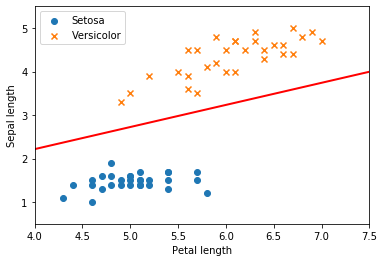

KeyboardInterrupt: 

In [12]:
train_samples = CSVDataLoader.load_samples('./data/iris_virginica/iris_virginica_train_60_samples.csv', ',', True)
train_labels = CSVDataLoader.load_labels('./data/iris_virginica/iris_virginica_train_60_labels.csv', ',', True)
test_samples = CSVDataLoader.load_samples('./data/iris_virginica/iris_virginica_train_60_samples.csv', ',', True)
test_labels = CSVDataLoader.load_labels('./data/iris_virginica/iris_virginica_train_60_labels.csv', ',', True)

binary_classifier = BinaryClassifier(train_samples.shape[1])
binary_classifier.train(train_samples, train_labels, 0.8, 20)

NeuralSystemPicker.save_neural_system('./serialized_objects/binary_classifier', binary_classifier)
binary_classifier = NeuralSystemPicker.load_neural_system('./serialized_objects/binary_classifier.snn')

print(binary_classifier.calculate_error_rate(test_samples, test_labels))

plt.scatter(np.array(train_samples[:30, 0]), np.array(train_samples[:30, 1]), marker='o', label='Setosa')
plt.scatter(np.array(train_samples[30:, 0]), np.array(train_samples[30:, 1]), marker='x', label='Versicolor')
plt.xlabel('Petal length')
plt.ylabel('Sepal length')
plt.legend()

weights = binary_classifier.weights
x = np.linspace(4, 7.5, 100)
y = (-1) * (weights[1] * x + weights[0]) / weights[2]
plt.plot(x, y, '-r', linewidth=2)

axes = plt.gca()
axes.set_xlim(4, 7.5)
axes.set_ylim(0.5, 5.5)
plt.show()

plt.plot(binary_classifier.misclassified_samples_per_epoch)
plt.axis([0, 6, 0, 5])
plt.ylabel('Miss classified samples')
plt.xlabel('Iteration')
plt.show()


### 7.2. Clasificador multiclase.

Ubicación: `simple_neural_network/neural_systems/multiclass_classifier/multiclass_classifier.py`

Este sistema es capaz de clasificar una serie de muestras en N clases diferentes, haciendo uso de N neuronas para ello.
Al igual que ocurría con el clasificador binario, la frontera de decisión entre dos clases sigue siendo lineal.

<img src="images/Multiclass_classifier.png" width="700"/>

Elementos que componen al clasificador multiclase:

* Constructor:
    * `MulticlassClassifier(number_of_inputs, number_of_classes)`: constructor de un objeto de tipo `MulticlassClassifier`.

        Parámetros:
        * `number_of_inputs`: entero que indica el número de entradas de la neurona (dimensión de las muestras).
        * `number_of_classes`: entero que indica el número de clases del sistema.

* Atributos:
    * `__number_of_classes`: atributo de tipo entero que indica el número de clases del sistema.
    * `__neurons`: lista con objetos de tipo `Neuron` cuya dimensión es igual al número de clases del sistema.
    Se instancian haciendo uso de la función de activación escalón `ActivationFunctionsEnum.IDENTITY_FUNCTION`.
    Cada una de estas neuronas será la responsable de realizar la clasificación de cada muestra en cada una de las diferentes clases.
    * `__learning_rate`: atributo que define la velocidad de aprendizaje del algoritmo, valores próximos a cero suponen convergencias más suaves pero con más iteraciones.
    * `__max_epochs`: atributo que define la cantidad máxima de iteraciones que realizará el algoritmo en caso de que las muestras no sean linealmente separables.
    * `__miss_classified_samples_per_epoch`: es una lista donde cada elemento corresponde al número de muestras mal clasificadas en la iteración pos + 1 de la lista.
    Es decir `__miss_classified_samples_per_epoch[x]` corresponde al número de muestras mal clasificadas en la iteración x + 1.

* Funciones:
    * `number_of_classes()`: consultor del atributo `__number_of_classes`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el constructor y no debe cambiar durante la ejecución.
    * `learning_rate()`: consultor del atributo `__learning_rate`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el método `train(samples, labels, learning_rate, max_epochs)` y no debe cambiar durante la ejecución.
    * `max_epochs()`: consultor del atributo `__max_epochs`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el método `train(samples, labels, learning_rate, max_epochs)` y no debe cambiar durante la ejecución.
    * `miss_classified_samples_per_epoch()`: consultor del atributo `__miss_classified_samples_per_epoch`. En este caso no se define un modificador ya que este atributo se genera en tiempo de ejecución.
    * `epochs()`: esta función nos devuelve el número total iteraciones realizadas durante el proceso de entrenamiento. Su valor se obtiene de la dimensión del atributo `__miss_classified_samples_per_epoch`.
    * `weights()`: devuelve una lista con los pesos de cada una de las neuronas del atributo `__neurons`.
    * `train(samples, labels, learning_rate, max_epochs)`: función encargada de realizar el entrenamiento del sistema, el algoritmo utilizado es el del perceptrón con la modalidad del atributo rate para la velocidad de entrenamiento.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, M a la dimensión de las misma y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].
        * `learning_rate`: velocidad de aprendizaje del algoritmo; por defecto su valor es 1 `MULTICLASS_CLASSIFIER.get('LEARNING_RATE_DEFAULT_VALUE')`.
        * `max_epochs`: número máximo de iteraciones del algoritmo; por defecto su valor es 10 `MULTICLASS_CLASSIFIER.get('MAX_EPOCHS_DEFAULT_VALUE')`.

    El algoritmo corrige tanto los pesos de cada neurona que provoca error como el de la neurona que debría haber clasificado correctamente la muestra.
    Este algoritmo se ejecuta hasta que o bien haya clasificado correctamente todas las muestras en una misma iteración o se alcance el máximo número de iteraciones.

    * `classify(sample)`: función encargada de clasificar una muestra, de vuelve un valor c perteneciente al conjunto {1, ..., C}, siendo C el número de clases.

        Parámetros:
        * `sample`: un `np.array` de tipo `np.double` que representa una a una muestra.

    * `calculate_error_rate(samples, labels):`: función encargada de calcular la tasa de error cometida por el sistema al clasificar las muestras entregadas como parámetros con sus respectivas etiquetas.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, M a la dimensión de las misma y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

In [ ]:
class MulticlassClassifier:

    def __init__(self, number_of_inputs, number_of_classes):
        self.__number_of_classes = number_of_classes
        self.__neurons = [Neuron(number_of_inputs, ActivationFunctionsEnum.IDENTITY_FUNCTION)
                          for _ in range(number_of_classes)]
        self.__learning_rate = MULTICLASS_CLASSIFIER.get('LEARNING_RATE_DEFAULT_VALUE')
        self.__max_epochs = MULTICLASS_CLASSIFIER.get('MAX_EPOCHS_DEFAULT_VALUE')
        self.__misclassified_samples_per_epoch = []

    @property
    def number_of_classes(self):
        return self.__number_of_classes

    @property
    def learning_rate(self):
        return self.__learning_rate

    @property
    def max_epochs(self):
        return self.__max_epochs

    @property
    def misclassified_samples_per_epoch(self):
        return self.__misclassified_samples_per_epoch

    @property
    def epochs(self):
        return len(self.__misclassified_samples_per_epoch)

    @property
    def weights(self):
        return [neuron.weights for neuron in self.__neurons]

    def train(self, samples, labels, learning_rate=MULTICLASS_CLASSIFIER.get('LEARNING_RATE_DEFAULT_VALUE'),
              max_epochs=MULTICLASS_CLASSIFIER.get('MAX_EPOCHS_DEFAULT_VALUE')):
        self.__learning_rate = learning_rate
        self.__max_epochs = max_epochs
        epoch = 0

        while True:
            well_classified_samples = 0
            misclassified_samples = 0

            for sample, label in zip(samples, labels):

                well_classifier_value = self.__neurons[label[0]].calculate_output(sample)
                error = False

                for classifier in [classifier for classifier in range(self.number_of_classes)
                                   if classifier != label[0]]:
                    wrong_classifier_value = self.__neurons[classifier].calculate_output(sample)

                    if wrong_classifier_value > well_classifier_value:
                        self.__neurons[classifier].weights -= (self.learning_rate * np.append(1, sample))
                        error = True

                    if error:
                        self.__neurons[label[0]].weights += (self.learning_rate * np.append(1, sample))

                if error:
                    misclassified_samples += 1
                else:
                    well_classified_samples += 1

            epoch += 1
            self.misclassified_samples_per_epoch.append(misclassified_samples)
            Logger.print_error_rate_message(epoch, misclassified_samples, len(samples),
                                            (misclassified_samples / len(samples)))

            if epoch == self.max_epochs or well_classified_samples == samples.shape[0]:
                break

    def classify(self, sample):
        results = [neuron.calculate_output(sample) for neuron in self.__neurons]
        return results.index(max(results))

    def calculate_error_rate(self, samples, labels):
        errors = 0

        for sample, label in zip(samples, labels):
            if self.classify(sample) != label[0]:
                errors += 1

        return errors / len(labels)


#### 7.2.1. Ejemplo de uso del clasificador multiclase.

Ubicación: `usage_multiclass_classifer.py`

Uso: `python src/usage_multiclass_classifer.py`

En este archivo se realiza un ejemplo de uso del clasificador multiclase con un set de datos real como es el de mnist.

Se dispone de cuatro archivos .csv en el directorio `/data/mnist` estos archivos contienen los valores de las imágenes de 28 x 28 píxeles en escala de grises de los dígitos manuscritos comprendidos entre el 0 y el 9, ambos inclusive:
* `mnist_train_40K_samples.csv` e `mnist_train_40K_labels.csv` son las muestras y etiquetas utilizadas para el entrenamiento del sistema.
* `mnist_test_10K_samples.csv` e `mnist_test_10K_labels.csv` son las muestras y etiquetas utilizadas para obtener la tasa de error obtenido por el sistema una vez entrenado.

En primer lugar se cargan los datos `train_samples`, `train_labels`, `train_labels` y `test_labels` haciendo uso de `CSVData`.
Posteriormente se normalizan estos haciendo uso de `Normalization.z_score(data)`.

Instanciamos un `MulticlassClassifier(train_samples_normalized.shape[1], 10)`, donde `train_samples_normalized.shape[1] = dimensión de la primera muestra = 784` y `10` es el número de clases diferentes.
Entrenamos el sistema con `multiclass_classifier.train(train_samples_normalized, train_labels)`. Nótese como en este caso no se indican los valores para los parámetros `learning_rate` y `max_epochs`.
tomándose los valores por defecto 1 y 10 respectivamente.

Calculamos la tasa de error obtenida por el sistema haciendo uso de la función `multiclass_classifier.calculate_error_rate(test_samples_normalized, test_labels)` y lo mostramos por consola.

In [ ]:
train_samples = CSVDataLoader.load_samples('./data/mnist/mnist_train_40K_samples.csv', ';', False)
train_labels = CSVDataLoader.load_labels('./data/mnist/mnist_train_40K_labels.csv', ';', False)
test_samples = CSVDataLoader.load_samples('./data/mnist/mnist_test_10K_samples.csv', ';', False)
test_labels = CSVDataLoader.load_labels('./data/mnist/mnist_test_10K_labels.csv', ';', False)

train_samples_normalized = Normalization.z_score(train_samples)
test_samples_normalized = Normalization.z_score(test_samples)

multiclass_classifier = MulticlassClassifier(train_samples_normalized.shape[1], 10)
multiclass_classifier.train(train_samples_normalized, train_labels)

NeuralSystemPicker.save_neural_system('./serialized_objects/multiclass_classifier', multiclass_classifier)
multiclass_classifier = NeuralSystemPicker.load_neural_system('./serialized_objects/multiclass_classifier.snn')

print(multiclass_classifier.calculate_error_rate(test_samples_normalized, test_labels))


### 7.3. Red neuronal artificial multicapa.

Ubicación: `simple_neural_network/neural_systems/multilayer_neural_network/multilayer_neural_network.py`

Este sistema es capaz de clasificar una serie de muestras en N clases diferentes, haciendo uso de N neuronas para ello.
A diferencia de lo que ocurría con el clasificador multiclase, la frontera de decisión entre dos clases ya no es lineal.

<img src="images/Multilayer_neural_network.png" width="700"/>

Para la función del _error cuadrático medio_ (`LossFunctionsEnum.MSE_FUNCTION`) las ecuaciones de propagación hacia delante, de cálculo del error y corrección de los pesos son las siguientes.

Para simplificar, pero sin perdida de generalidad, la figura representa una red neuronal multicapa con dos capas ocultas.
La arquitectura y las notaciones de las ecuaciones de propagación hacia delante y hacia atrás son extensibles a cualquier número de capas ocultas.

* La propagación hacia delante de las diferentes capas, suponiendo que la dimensión de entrada es t, el número de perceptrones de la primera capa oculta es n, el de la segunda capa oculta es m,
el número de clases es C y una muestra X se define a continuación:
    * Primera capa oculta: $S^1_i(X) = f(\sum_{j = 0}^{t}W^1_{ij} X_j \quad \forall 1 \le i \le n)$
    * Segunda capa oculta: $S^2_i(X) = f(\sum_{j = 0}^{n}W^2_{ij} S^1_j \quad \forall 1 \le i \le m)$
    * Capa de salida: $S^3_i(X) = f(\sum_{j = 0}^{m}W^3_{ij} S^2_j \quad \forall 1 \le i \le C)$

* Las ecuaciones de propagación hacia atrás para la corrección de los pesos dada una muestra X son las siguientes. Siendo $\rho$ el factor de aprendizaje.
    * Capa de salida $(1 \le i \le C, 0 \le j \le m)$:
        * Error: $\delta^1_i(X) = (t_i-S^3_i(X))f'(\sum_{j = 0}^{m}W^3_{ij}S^2_j(X))$
        * Corrección de los pesos: $W^3_{ij} = W^3_{ij} + \rho\delta^3_i(X)S^2_j(X)$
    * Segunda capa oculta $(1 \le i \le m, 0 \le j \le n)$:
        * Error: $\delta^2_i(X) = (\sum_{r = 1}^{C}\delta^3_r(X)W^3_{ri})f'(\sum_{j = 0}^{n}W^2_{ij}S^1_j(X))$
        * Corrección de los pesos: $W^2_{ij} = W^2_{ij} + \rho\delta^2_i(X)S^1_j(X)$
    * Capa de salida $(1 \le i \le n, 0 \le j \le t)$:
        * Error: $\delta^1_i(X) = (\sum_{r = 1}^{m}\delta^2_r(X)W^2_{ri})f'(\sum_{j = 0}^{t}W^1_{ij}X_j)$
        * Corrección de los pesos: $W^1_{ij} = W^1_{ij} + \rho\delta^1_i(X)X_j$

Elementos que componen a la red neuronal artificial multicapa:

* Constructor:
    * `MultilayerNeuralNetwork(layers_definition)`: constructor de un objeto de tipo `MultilayerNeuralNetwork`.

        Parámetros:
        * `layers_definition`: se trata de una lista con la definición de cada una de las capas que componen el sistema, siendo cada elemento una lista con dos elementos,
        el primero un entero que hace referencia al número de neurona de la capa y el segundo al tipo de función de activación utilizada en las neuronas de esa capa.
        De tal forma que el primer elemento de la lista representa la capa 0 del sistema y por tanto la dimensión de las muestras, en este caso no es necesario definir una función de activación.
        `[[784], [20, ActivationFunctionsEnum.SIGMOID_FUNCTION], [10, ActivationFunctionsEnum.SIGMOID_FUNCTION]]`, en este caso se está definiendo una red con una capa de entrada de 784 entradas,
        una capa oculpa con 20 neuronas que implementan una función de activación de tipo sigmoide y una capa de salidar con 10 neuronas que implementan una función de activación de tipo sigmoide.

* Atributos:
    * `__number_of_classes`: atributo de tipo entero que indica el número de clases del sistema.
    * `__layers`: lista de listas de tipo Neuron, se construye a partir del atributo `layers_definition` recibido a través del constructor.
    * `__learning_rate`: atributo que define la velocidad de aprendizaje del algoritmo, valores próximos a cero suponen convergencias más suaves pero con más iteraciones.
    * `__max_epochs`: atributo que define la cantidad máxima de iteraciones que realizará el algoritmo en caso de que las muestras no sean linealmente separables.
    * `__miss_classified_samples_per_epoch`: es una lista donde cada elemento corresponde al número de muestras mal clasificadas en la iteración pos + 1 de la lista.
    Es decir `__miss_classified_samples_per_epoch[x]` corresponde al número de muestras mal clasificadas en la iteración x + 1.

* Funciones:
    * `number_of_classes()`: consultor del atributo `__number_of_classes`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el constructor y no debe cambiar durante la ejecución.
    * `learning_rate()`: consultor del atributo `__learning_rate`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el método `train(samples, labels, learning_rate, max_epochs)` y no debe cambiar durante la ejecución.
    * `max_epochs()`: consultor del atributo `__max_epochs`. En este caso no se define un modificador ya que la definición de este atributo se realiza en el método `train(samples, labels, learning_rate, max_epochs)` y no debe cambiar durante la ejecución.
    * `miss_classified_samples_per_epoch()`: consultor del atributo `__miss_classified_samples_per_epoch`. En este caso no se define un modificador ya que este atributo se genera en tiempo de ejecución.
    * `weights()`: devuelve una lista con los pesos de cada una de las neuronas del atributo `__layers`. Siendo `weights[l][n][w]` el peso _w_ correspondiente a la neurona _n_ de la capa _l_.
    * `__forward_propagation(sample)`: función privada encargada de calcular la propagación hacia delante de cada una de las capas de la red, devuelve una lista de valores correspondientes a las salidas obtenidas por las neuronas de cada capa.
    Siendo `forward_propagation[l][n]` el valor de slida obtenido por la neurona _n_ en la capa _l_.

        Parámetros:
        * `sample`: un `np.array` de tipo `np.double` que representa una a una muestra.

    * `__generate_expected_output(label)`: función privada encargada de generar y devolver una lista de dimensión igual al número de clases con valor igual a uno en la posición de la lista correspondiente al valor `label` y valor 0 en el resto de las posiciones.

        Parámetros:
        * `label`: un `np.intc` que representa la etiqueta de la muestra.

    * `__mse_calculate_errors_per_layer(outputs_per_layer, expected_output)`: función privada encargada de calcular los errores cometidos por cada neurona de cada una de las capas del sistema, devuelve una lista donde,
    `mse_calculate_errors_per_layer[l][n]` corresponde al error de salida obtenido por la neurona _n_ en la capa _l_.
    La llamada a esta función desencadena la llamada de las funciones `__mse_calculate_output_layer_errors(outputs_per_layer, expected_output)` y `__mse_calculate_hidden_layer_errors(layer, outputs_per_layer, errors_per_layer)`
    para calcular los errores generados en la última capa y las capas ocultas respectivamente. Esto es así ya que la ecuación para calcular el error de cada capa es diferente para la última capa y las ocultas.

        Parámetros:
        * `outputs_per_layer`: lista generada en la llamada a la función `__forward_propagation(sample)`.
        * `expected_output`: lista generada en la llamada a la función `__generate_expected_output(label)`.

    * `__mse_calculate_output_layer_errors(outputs_per_layer, expected_output)`: función privada encargada de calcular los errores cometidos por cada neurona de la capa de salida, devuelve una lista donde,
    `mse_calculate_output_layer_errors[n]` corresponde al error de salida obtenido por la neurona _n_ de la capa de salida.

        Parámetros:
        * `outputs_per_layer`: lista generada en la llamada a la función `__forward_propagation(sample)`.
        * `expected_output`: lista generada en la llamada a la función `__generate_expected_output(label)`.

    * `__mse_calculate_hidden_layer_errors(layer, outputs_per_layer, errors_per_layer)`: función privada encargada de calcular los errores cometidos por cada neurona de la capa de oculta `layer`, devuelve una lista donde,
    `mse_calculate_output_layer_errors[n]` corresponde al error de salida obtenido por la neurona _n_ de la capa oculta `layer`.

        Parámetros:
        * `layer`: valor entero que hace referencia a la capa oculta.
        * `outputs_per_layer`: lista generada en la llamada a la función `__forward_propagation(sample)`.
        * `errors_per_layer`: lista que contiene los errores cometidos por cada neurona de cada una de las capas del sistema posteriores a la capa `layer`,
        para calcular el error cometido en la capa _n_ se deben conocer los errores cometidos en la capa _n+1_.

    * `__mse_correct_weights(outputs_per_layer, errors_per_layer)`: función privada encargada de corregir los pesos de cada una de las neuronas que conforman la red.

        Parámetros:
        * `outputs_per_layer`: lista generada en la llamada a la función `__forward_propagation(sample)`.
        * `errors_per_layer`: lista generada en la llamada a la función `__mse_calculate_output_layer_errors(outputs_per_layer, expected_output)`.

    * `__mse_back_propagation(outputs_per_layer, expected_output)`: función privada encargada del entrenamiento del sistema para el tipo de función de coste _error cuadrático medio_ (`LossFunctionsEnum.MSE_FUNCTION`).
    Su llamada desencadena la ejecución de las funciones `__mse_calculate_errors_per_layer(outputs_per_layer, expected_output)` y `__mse_correct_weights(outputs_per_layer, errors_per_layer)`.

        Parámetros:
        * `outputs_per_layer`: lista generada en la llamada a la función `__forward_propagation(sample)`.
        * `expected_output`: lista generada en la llamada a la función `__generate_expected_output(label)`.

    * `train(samples, labels, loss_function, learning_rate, max_epochs)`: función encargada de realizar el entrenamiento del sistema, el algoritmo utilizado es el del perceptrón con la modalidad del atributo rate para la velocidad de entrenamiento.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, M a la dimensión de las misma y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].
        * `loss_function`: función de coste del algoritmo; por defecto el _error cuadrático medio_ (`LossFunctionsEnum.MSE_FUNCTION`).
        * `learning_rate`: velocidad de aprendizaje del algoritmo; por defecto su valor es 0.1 `MULTILAYER_NEURAL_NETWORK.get('LEARNING_RATE_DEFAULT_VALUE')`.
        * `max_epochs`: número máximo de iteraciones del algoritmo; por defecto su valor es 20 `MULTILAYER_NEURAL_NETWORK.get('MAX_EPOCHS_DEFAULT_VALUE')`.

    * `classify(sample)`: función encargada de clasificar una muestra, de vuelve un valor c perteneciente al conjunto {1, ..., C}, siendo C el número de clases.

        Parámetros:
        * `sample`: un `np.array` de tipo `np.double` que representa una a una muestra.

    * `calculate_error_rate(samples, labels):`: función encargada de calcular la tasa de error cometida por el sistema al clasificar las muestras entregadas como parámetros con sus respectivas etiquetas.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, M a la dimensión de las misma y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

In [ ]:
class MultilayerNeuralNetwork:

    def __init__(self, layers_definition):
        self.__number_of_classes = layers_definition[-1][MULTILAYER_NEURAL_NETWORK.get('NEURON_DIMENSION')]
        self.__layers = [
            [
                Neuron(
                    layers_definition[layer - 1][MULTILAYER_NEURAL_NETWORK.get('NEURON_DIMENSION')],
                    layers_definition[layer][MULTILAYER_NEURAL_NETWORK.get('NEURON_ACTIVATION_FUNCTION')]
                )
                for _ in range(layers_definition[layer][MULTILAYER_NEURAL_NETWORK.get('NEURON_DIMENSION')])
            ]
            for layer in range(1, len(layers_definition))
        ]
        self.__learning_rate = MULTILAYER_NEURAL_NETWORK.get('LEARNING_RATE_DEFAULT_VALUE')
        self.__max_epochs = MULTILAYER_NEURAL_NETWORK.get('MAX_EPOCHS_DEFAULT_VALUE')
        self.__misclassified_samples_per_epoch = []

    @property
    def number_of_classes(self):
        return self.__number_of_classes

    @property
    def number_of_layers(self):
        return len(self.__layers)

    @property
    def learning_rate(self):
        return self.__learning_rate

    @property
    def max_epochs(self):
        return self.__max_epochs

    @property
    def misclassified_samples_per_epoch(self):
        return self.__misclassified_samples_per_epoch

    @property
    def weights(self):
        return [[neuron.weights for neuron in layer] for layer in self.__layers]

    def __forward_propagation(self, sample):
        outputs_per_layer = [sample]

        for layer in range(self.number_of_layers):
            outputs_per_layer.append(
                [neuron.calculate_output(outputs_per_layer[layer]) for neuron in self.__layers[layer]]
            )

        return outputs_per_layer

    def classify(self, sample):
        results = self.__forward_propagation(sample)[-1]
        return results.index(max(results))

    def calculate_error_rate(self, samples, labels):
        errors = 0

        for sample, label in zip(samples, labels):
            if self.classify(sample) != label[0]:
                errors += 1

        return errors / len(labels)

    def __generate_expected_output(self, label):
        expected_output = [0] * self.number_of_classes
        expected_output[label] = 1
        return expected_output

    def __mse_calculate_errors_per_layer(self, outputs_per_layer, expected_output):
        errors_per_layer = []
        errors_per_layer.insert(0, self.__mse_calculate_output_layer_errors(outputs_per_layer, expected_output))

        for layer in range(self.number_of_layers - 2, -1, -1):
            errors_per_layer.insert(0, self.__mse_calculate_hidden_layer_errors(layer, outputs_per_layer, errors_per_layer))

        return errors_per_layer

    def __mse_calculate_output_layer_errors(self, outputs_per_layer, expected_output):
        return [(expected_output[output] - outputs_per_layer[-1][output])
                * outputs_per_layer[-1][output]
                * (1 - outputs_per_layer[-1][output])
                for output in range(self.number_of_classes)]

    def __mse_calculate_hidden_layer_errors(self, layer, outputs_per_layer, errors_per_layer):

        return [
            (np.dot([self.__layers[layer + 1][neuron_next_layer].weights[neuron + 1]
                     for neuron_next_layer in range(len(self.__layers[layer + 1]))], errors_per_layer[0])
             * outputs_per_layer[layer + 1][neuron]
             * (1 - outputs_per_layer[layer + 1][neuron]))
            for neuron in range(len(self.__layers[layer]))]

    def __mse_correct_weights(self, outputs_per_layer, errors_per_layer):
        outputs_per_layer_with_cte = [np.append(1, output) for output in outputs_per_layer]

        for layer in range(self.number_of_layers - 1, -1, -1):
            for neuron in range(len(self.__layers[layer])):
                for weight in range(len(self.__layers[layer][neuron].weights)):
                    self.__layers[layer][neuron].weights[weight] += self.learning_rate \
                                                                    * errors_per_layer[layer][neuron] \
                                                                    * outputs_per_layer_with_cte[layer][weight]

    def __mse_back_propagation(self, outputs_per_layer, expected_output):
        errors_per_layer = self.__mse_calculate_errors_per_layer(outputs_per_layer, expected_output)
        self.__mse_correct_weights(outputs_per_layer, errors_per_layer)

    def train(self, samples, labels, loss_function=LossFunctionsEnum.MSE_FUNCTION,
              learning_rate=MULTILAYER_NEURAL_NETWORK.get('LEARNING_RATE_DEFAULT_VALUE'),
              max_epochs=MULTILAYER_NEURAL_NETWORK.get('MAX_EPOCHS_DEFAULT_VALUE')):
        self.__learning_rate = learning_rate
        self.__max_epochs = max_epochs
        epoch = 0

        while True:
            misclassified_samples = 0

            for sample, label in zip(samples, labels):

                outputs_per_layer = self.__forward_propagation(sample)
                result = outputs_per_layer[-1].index(max(outputs_per_layer[-1]))

                if result != label[0]:
                    misclassified_samples += 1

                if loss_function is LossFunctionsEnum.MSE_FUNCTION:
                    self.__mse_back_propagation(outputs_per_layer,
                                                self.__generate_expected_output(label[0]))

            epoch += 1
            self.misclassified_samples_per_epoch.append(misclassified_samples)
            Logger.print_error_rate_message(epoch, misclassified_samples, len(samples),
                                            (misclassified_samples / len(samples)))

            if epoch == self.max_epochs:
                break


#### 7.3.1. Ejemplo de uso de una red neuronal artificial multicapa.

Ubicación: `usage_multilayer_neural_network.py`

Uso: `python src/usage_multilayer_neural_network.py`

En este archivo se realiza un ejemplo de uso de una red neuronal artificial multicapa con un set de datos real como es el de mnist.

Se dispone de cuatro archivos .csv en el directorio `/data/mnist` estos archivos contienen los valores de las imágenes de 28 x 28 píxeles en escala de grises de los dígitos manuscritos comprendidos entre el 0 y el 9, ambos inclusive:
* `mnist_train_40K_samples.csv` e `mnist_train_40K_labels.csv` son las muestras y etiquetas utilizadas para el entrenamiento del sistema.
* `mnist_test_10K_samples.csv` e `mnist_test_10K_labels.csv` son las muestras y etiquetas utilizadas para obtener la tasa de error obtenido por el sistema una vez entrenado.

En primer lugar se cargan los datos `train_samples`, `train_labels`, `train_labels` y `test_labels` haciendo uso de `CSVData`.
Posteriormente se normalizan estos haciendo uso de `Normalization.z_score(data)`.

Instanciamos un `MultilayerNeuralNetwork(train_samples_normalized.shape[1], 10)`, donde `train_samples_normalized.shape[1] = dimensión de la primera muestra = 784` y `10` es el número de clases diferentes.
Entrenamos el sistema con `multilayer_neural_network.train(train_samples_normalized, train_labels, LossFunctionsEnum.MSE_FUNCTION, 0.1, 20)`.

Calculamos la tasa de error obtenida por el sistema haciendo uso de la función `multilayer_neural_network.calculate_error_rate(test_samples_normalized, test_labels)` y lo mostramos por consola.

In [ ]:
train_samples = CSVDataLoader.load_samples('./data/mnist/mnist_train_40K_samples.csv', ';', False)
train_labels = CSVDataLoader.load_labels('./data/mnist/mnist_train_40K_labels.csv', ';', False)
test_samples = CSVDataLoader.load_samples('./data/mnist/mnist_test_10K_samples.csv', ';', False)
test_labels = CSVDataLoader.load_labels('./data/mnist/mnist_test_10K_labels.csv', ';', False)

train_samples_normalized = Normalization.z_score(train_samples)
test_samples_normalized = Normalization.z_score(test_samples)

multilayer_neural_network = MultilayerNeuralNetwork([[train_samples_normalized.shape[1]],
                                                     [20, ActivationFunctionsEnum.SIGMOID_FUNCTION],
                                                     [10, ActivationFunctionsEnum.SIGMOID_FUNCTION]])
multilayer_neural_network.train(train_samples_normalized, train_labels, LossFunctionsEnum.MSE_FUNCTION, 0.1, 20)

NeuralSystemPicker.save_neural_system('./serialized_objects/multilayer_neural_network', multilayer_neural_network)
multilayer_neural_network = NeuralSystemPicker.load_neural_system('./serialized_objects/multilayer_neural_network.snn')

print(multilayer_neural_network.calculate_error_rate(test_samples_normalized, test_labels))
